In [2]:
# Imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from matplotlib import patches
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:

# Network, ready to use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2, padding_mode='zeros')
        self.pool = nn.MaxPool2d(2, 2) #Pooling 2 by 2, window of 2
        self.conv2 = nn.Conv2d(32, 64, 5 , padding=2, padding_mode='zeros')
        #self.conv3 = nn.Conv2d(64, 128, 5, padding=2, padding_mode='zeros')
        self.fc1 = nn.Linear(64 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [4]:
# Network creation
net = Net()

In [5]:
# Calculate Entropy error -> test accuracy of model, we want criterion to tend to 0.
# Optimize change network each time to make it better. It's ran between every batches


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:

#model.load_state_dict(torch.load(PATH))
net = torch.load("./Saved Models/model_95_test.pt")
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=2, bias=True)
)

In [7]:
originalImage = cv2.imread('./Images Visages/martin.jpg')
image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)/255.

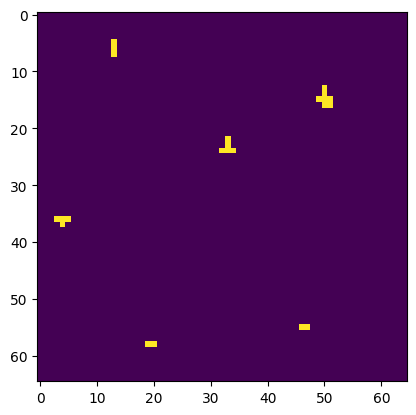

In [8]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((nb_windows,nb_windows))
cpt = 0
for i in range(nb_windows) :
    for j in range(nb_windows) :
        #cpt+=1
        small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]
        #print(cpt, small_image.shape)
        torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        outputs = net(torch_image)
        _, predicted = torch.max(outputs.data, 1)
        mat[i][j] = predicted

plt.imshow(mat)

array([[ 88, 268],
       [133, 183],
       [198,  38],
       [ 48,  83],
       [308, 113],
       [293, 248]])

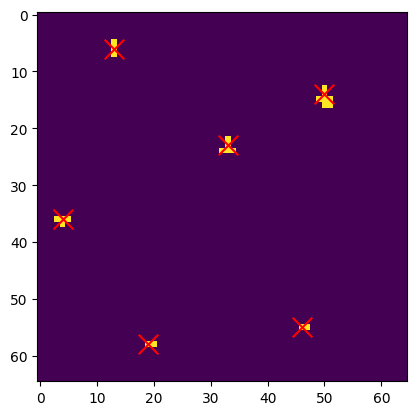

In [9]:
#cluster
array_of_points = [[i, j] for i in range(nb_windows) for j in range(nb_windows) if mat[i][j] == 1]

X = np.array(array_of_points)

clustering = MeanShift(bandwidth=3).fit(X)
centers = clustering.cluster_centers_
#centers = np.reshape(clustering.cluster_centers_, (nb_windows, nb_windows))
centers_faces = centers.astype(int)
plt.imshow(mat)
plt.scatter(centers_faces[:, 1], centers_faces[:, 0], marker="x", color="red", s=200)

#mat_centers = np.zeros((whole_size, whole_size))
#for idx, coord in enumerate(array_of_points):
centers_faces = centers_faces*step + int(size/2)
centers_faces

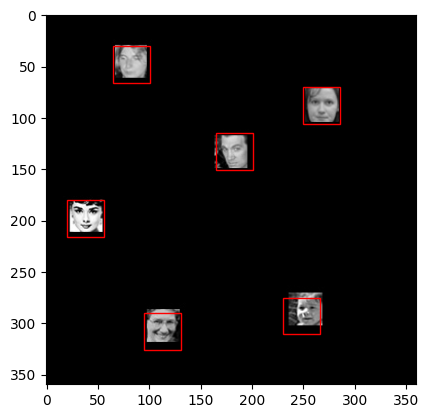

In [10]:
plt.imshow(originalImage)

top_right_corners = np.array(centers_faces)
top_right_corners[:, 1] -= int(size/2)
top_right_corners[:, 0] -= int(size/2)

#plt.scatter(top_right_corners[:, 1], top_right_corners[:, 0], marker="x", color="red", s=200)
ax = plt.gca()
for [x,y] in top_right_corners:
    rect = patches.Rectangle((y,x), size, size, linewidth=1, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)


### Pyramids


Resized Dimensions :  (360, 360)
1
Resized Dimensions :  (306, 306)
2
Resized Dimensions :  (260, 260)
3


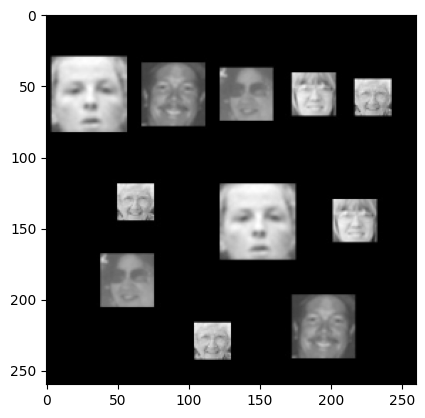

In [11]:
pyramid = []

img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.

resized_factors = [1/(0.85 ** i) for i in range(0,3)]

for resized_factor in resized_factors :

  width = int(img.shape[1] / resized_factor)
  height = int(img.shape[0] / resized_factor)
  dim = (width, height)
    
  # resize image
  new_img = cv2.resize(img, dim)
  #new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)/255.
  print('Resized Dimensions : ', new_img.shape)
  
  #new_img = cv2.cvtColor(new_img)
  #new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)/255.
  plt.imshow(new_img, cmap='gray')
  
  pyramid.append(new_img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  print(len(pyramid))


In [12]:
def get_face_centers(array_of_points, resised_factor):
    # array_of_points = [[i, j] for i in range(nb_windows) for j in range(nb_windows) if mat[i][j] == 1]

    X = np.array(array_of_points)

    clustering = MeanShift(bandwidth=20).fit(X)
    # center coordinates
    centers = clustering.cluster_centers_
    #centers = np.reshape(clustering.cluster_centers_, (nb_windows, nb_windows))
    centers_faces = centers.astype(int)
    # plt.imshow(mat)
    # plt.scatter(centers_faces[:, 1], centers_faces[:, 0], marker="x", color="red", s=200)

    # add a column to centers to store the

    # for idx, coord in enumerate(array_of_points):
    # centers_faces = centers_faces*step + int(size/2)
    real_face_size = np.repeat(resised_factor*size, len(centers))
    centers_faces = np.c_[centers_faces, real_face_size]
    return centers_faces

In [13]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((360,360))
all_centers = None
for index, resized_factor in enumerate(resized_factors) :
    image = pyramid[index]
    whole_size = image.shape[0]
    nb_windows = int((whole_size - size + 1)/step)
    array_of_points_to_cluster = []

    for i in range(nb_windows) :
        for j in range(nb_windows) :
            center_window_x = step*i+size//2
            center_window_y = step*j+size//2

            small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]

            torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
            torch_image = torch.unsqueeze(torch_image, dim=0)
            torch_image = torch.unsqueeze(torch_image, dim=0)

            outputs = net(torch_image)
            _, predicted = torch.max(outputs.data, 1)
        #mat[int(center_window_x * resized_factor)][int(center_window_y  * resized_factor)] = predicted
            if predicted == 1:
                array_of_points_to_cluster.append([int(center_window_x * resized_factor), int(center_window_y  * resized_factor)])

    # get the centers_faces with the real size of the face
    current_centers = get_face_centers(array_of_points_to_cluster, resized_factor)
    #print(current_centers)
    all_centers = np.concatenate((all_centers, current_centers), axis=0) if all_centers is not None else current_centers

print(all_centers)


[[ 88.          52.          36.        ]
 [213.         216.          36.        ]
 [212.         195.          36.        ]
 [ 75.         110.          36.        ]
 [259.          83.          36.        ]
 [ 80.         130.          36.        ]
 [201.         300.          36.        ]
 [ 78.         259.          36.        ]
 [ 74.         201.          36.        ]
 [309.         276.          36.        ]
 [ 61.         139.          36.        ]
 [323.         160.          36.        ]
 [243.          65.          36.        ]
 [188.          85.          36.        ]
 [ 63.         183.          36.        ]
 [255.          83.          42.35294118]
 [ 75.         197.          42.35294118]
 [301.         260.          42.35294118]
 [ 78.         129.          42.35294118]
 [209.         218.          42.35294118]
 [209.         194.          42.35294118]
 [ 85.          53.          42.35294118]
 [ 77.         259.          42.35294118]
 [201.         299.          42.35

In [33]:
def get_face_centers2(array_of_points):
    # array_of_points = [[i, j] for i in range(nb_windows) for j in range(nb_windows) if mat[i][j] == 1]

    X = np.array(array_of_points)

    clustering = MeanShift(bandwidth=15).fit(X[:,0:2])
    # center coordinates
    centers = clustering.cluster_centers_
    #centers = np.reshape(clustering.cluster_centers_, (nb_windows, nb_windows))
    centers_faces = centers.astype(int)
    # plt.imshow(mat)
    # plt.scatter(centers_faces[:, 1], centers_faces[:, 0], marker="x", color="red", s=200)

    # add a column to centers to store the

    # for idx, coord in enumerate(array_of_points):
    # centers_faces = centers_faces*step + int(size/2)

    return centers_faces

In [34]:
a = get_face_centers2(array_of_points_to_cluster)

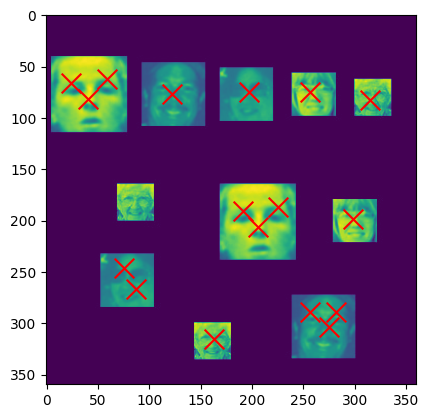

In [35]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.imshow(img)
#filter_arr = all_centers[:,2] == 70.31250
#newarr = all_centers[filter_arr]
#print(newarr)
#plt.scatter(all_centers[71:83, 1], all_centers[71:83, 0], marker="x", color="red", s=200)
plt.scatter(a[:, 1], a[:, 0], marker="x", color="red", s=200)

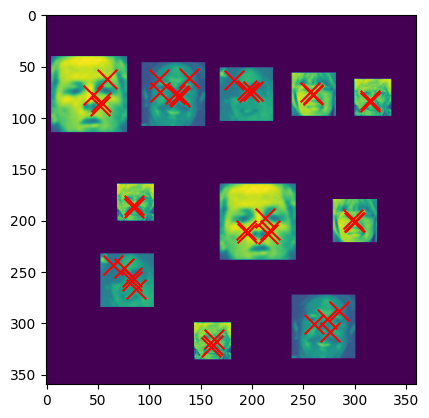

In [36]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.imshow(img)
#filter_arr = all_centers[:,2] == 70.31250
#newarr = all_centers[filter_arr]
#print(newarr)
#plt.scatter(all_centers[71:83, 1], all_centers[71:83, 0], marker="x", color="red", s=200)
plt.scatter(all_centers[:, 1], all_centers[:, 0], marker="x", color="red", s=200)